# Incense demo
This notebook demonstrates how `incense` can be used to retrieve experiments stored in a mongoDB by [sacred](https://github.com/IDSIA/sacred). It demonstrates the most of the capabilities of `incense` and should be enough to get you started.

If you want to run the notebook locally you will have to

1. start up the mongoDB service using docker. Go to `infrastructure/sacred_setup` and run `docker compose-up`
1. execute the example experiment. Got to `example/experiment` and run `python conduct.py`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('.')
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

import incense
from incense import ExperimentLoader
from tests.conftest import get_mongo_uri

## Finding experiments

To use `incense` we first have to instantiate an experiment loader that will enable us to query the database for specific runs.

In [3]:
loader = ExperimentLoader(
    mongo_uri=get_mongo_uri(),  # None if MongoDB is running on localhost or "mongodb://mongo:27017" when running in devcontainer.    
    db_name='incense_test'
)

It is easiest to retrieve experiments by their id.

In [4]:
exp = loader.find_by_id(2)
exp

Experiment(id=2, name=example)

It is also possible to find a set of experiments based on their configuration values. Multiple experiments are returned as a `QuerySet` that just acts as a list, but exposes some custom methods.

In [5]:
loader.find_by_config_key('optimizer', 'sgd')

QuerySet([Experiment(id=1, name=example), Experiment(id=2, name=example)])

In [6]:
loader.find_by_config_key('epochs', 3.0)

QuerySet([Experiment(id=2, name=example)])

For more complex queries we can rely on the full power of [mongoDB queries](https://docs.mongodb.com/manual/tutorial/query-documents/) using `find`.


In [7]:
query = {"$and": [
            {"config.optimizer": "sgd"},
            {"config.epochs": 3},
        ]}
loader.find(query)

QuerySet([Experiment(id=2, name=example)])

Using mongoDB queries you can also request experiments in certain time ranges.

In [8]:
query = {"start_time": {"$gt": datetime(2019, 4, 1)}}
loader.find(query)

QuerySet([Experiment(id=1, name=example), Experiment(id=2, name=example), Experiment(id=3, name=example)])

For quickly viewing the newest experiments you can use the `find_latest` method. This is especially useful when *debugging* machine learning experiments. Caching is explicitly disabled for this method.

In [9]:
loader.find_latest()

Experiment(id=3, name=example)

## Caching
By default, the experiment loader will cache the returned experiments. When you want to see updates in your in the database you have to explicitly clear the cache. Caching right now only works for `find`-methods that take immutable arguments.

In [10]:
loader.cache_clear()

## Accessing experiment attributes
The experiment object exposes all fields from the sacred data model. To see which keys and values are available we can use the `to_dict` method. 

In [11]:
exp.to_dict()

{'host': {'python_version': '3.6.8',
  'hostname': 'b8e84bb90a56',
  'os': ['Linux', 'Linux-4.18.0-25-generic-x86_64-with-debian-9.8'],
  'ENV': {},
  'cpu': 'Intel(R) Core(TM) i7-4800MQ CPU @ 2.70GHz'},
 'start_time': datetime.datetime(2019, 7, 25, 18, 38, 33, 832000),
 'resources': [],
 'info': {'metrics': [{'id': '5d39f733d0259dc4121890ad',
    'name': 'training_loss'},
   {'id': '5d39f733d0259dc4121890af', 'name': 'training_acc'},
   {'id': '5d39f73cd0259dc4121890e8', 'name': 'test_loss'},
   {'id': '5d39f73cd0259dc4121890ea', 'name': 'test_acc'}]},
 'stop_time': datetime.datetime(2019, 7, 25, 18, 38, 52, 8000),
 'meta': {'options': {'--print_config': False,
   '--unobserved': False,
   '--tiny_db': None,
   '--mongo_db': None,
   '--debug': False,
   '--file_storage': None,
   '--queue': False,
   '--sql': None,
   '--beat_interval': None,
   '--enforce_clean': False,
   '--force': False,
   '--capture': None,
   '--name': None,
   '--help': False,
   '--comment': None,
   '--prio

However, the experiment object exposes all keys as attributes, so they can be conveniently accessed using dot notation.

In [12]:
exp.status

'COMPLETED'

In [13]:
exp.start_time

datetime.datetime(2019, 7, 25, 18, 38, 33, 832000)

In [14]:
exp.result

0.9315000176429749

In [15]:
print(exp.captured_out)

INFO - example - Running command 'conduct'
INFO - example - Started run with ID "2"
Failed to detect content-type automatically for artifact /home/docker/workspace/predictions_df.pickle.
Added text/csv as content-type of artifact /home/docker/workspace/predictions.csv.
Added image/png as content-type of artifact /home/docker/workspace/confusion_matrix.png.
Added application/pdf as content-type of artifact /home/docker/workspace/confusion_matrix.pdf.
INFO - matplotlib.animation - MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '3840x2880', '-pix_fmt', 'rgba', '-r', '1', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'accuracy_movie.mp4']
Added video/mp4 as content-type of artifact /home/docker/workspace/accuracy_movie.mp4.
Added text/plain as content-type of artifact /home/docker/workspace/history.txt.
Failed to detect content-type automatically for artifact /home/docker/workspace/model.hdf5.
INFO - exampl

In [16]:
exp.config

pmap({'epochs': 3, 'optimizer': 'sgd', 'seed': 0})

This works down to deeper levels of the data model.

In [17]:
exp.config.epochs

3

Alternatively, the classic dictionary access notation can still be used. This is useful, if the the keys of the data model are not valid python identifiers.

In [18]:
exp.meta.options['--unobserved']

False

## Artifacts

`.artifacts` is a dict that maps from artifact names to artifact objects. The artifacts can rendered according to their type by calling `.render()` on them. They can be saved locally by calling `.save()` on them. The artifact dict might be empty if the run was just restarted and did not yet finish an epoch.

In [19]:
exp.artifacts

{'predictions_df': Artifact(name=predictions_df),
 'predictions': CSVArtifact(name=predictions),
 'confusion_matrix': ImageArtifact(name=confusion_matrix),
 'confusion_matrix.pdf': PDFArtifact(name=confusion_matrix.pdf),
 'accuracy_movie': MP4Artifact(name=accuracy_movie),
 'history': Artifact(name=history),
 'model.hdf5': Artifact(name=model.hdf5)}

PNG artifacts will be shown as images by default.

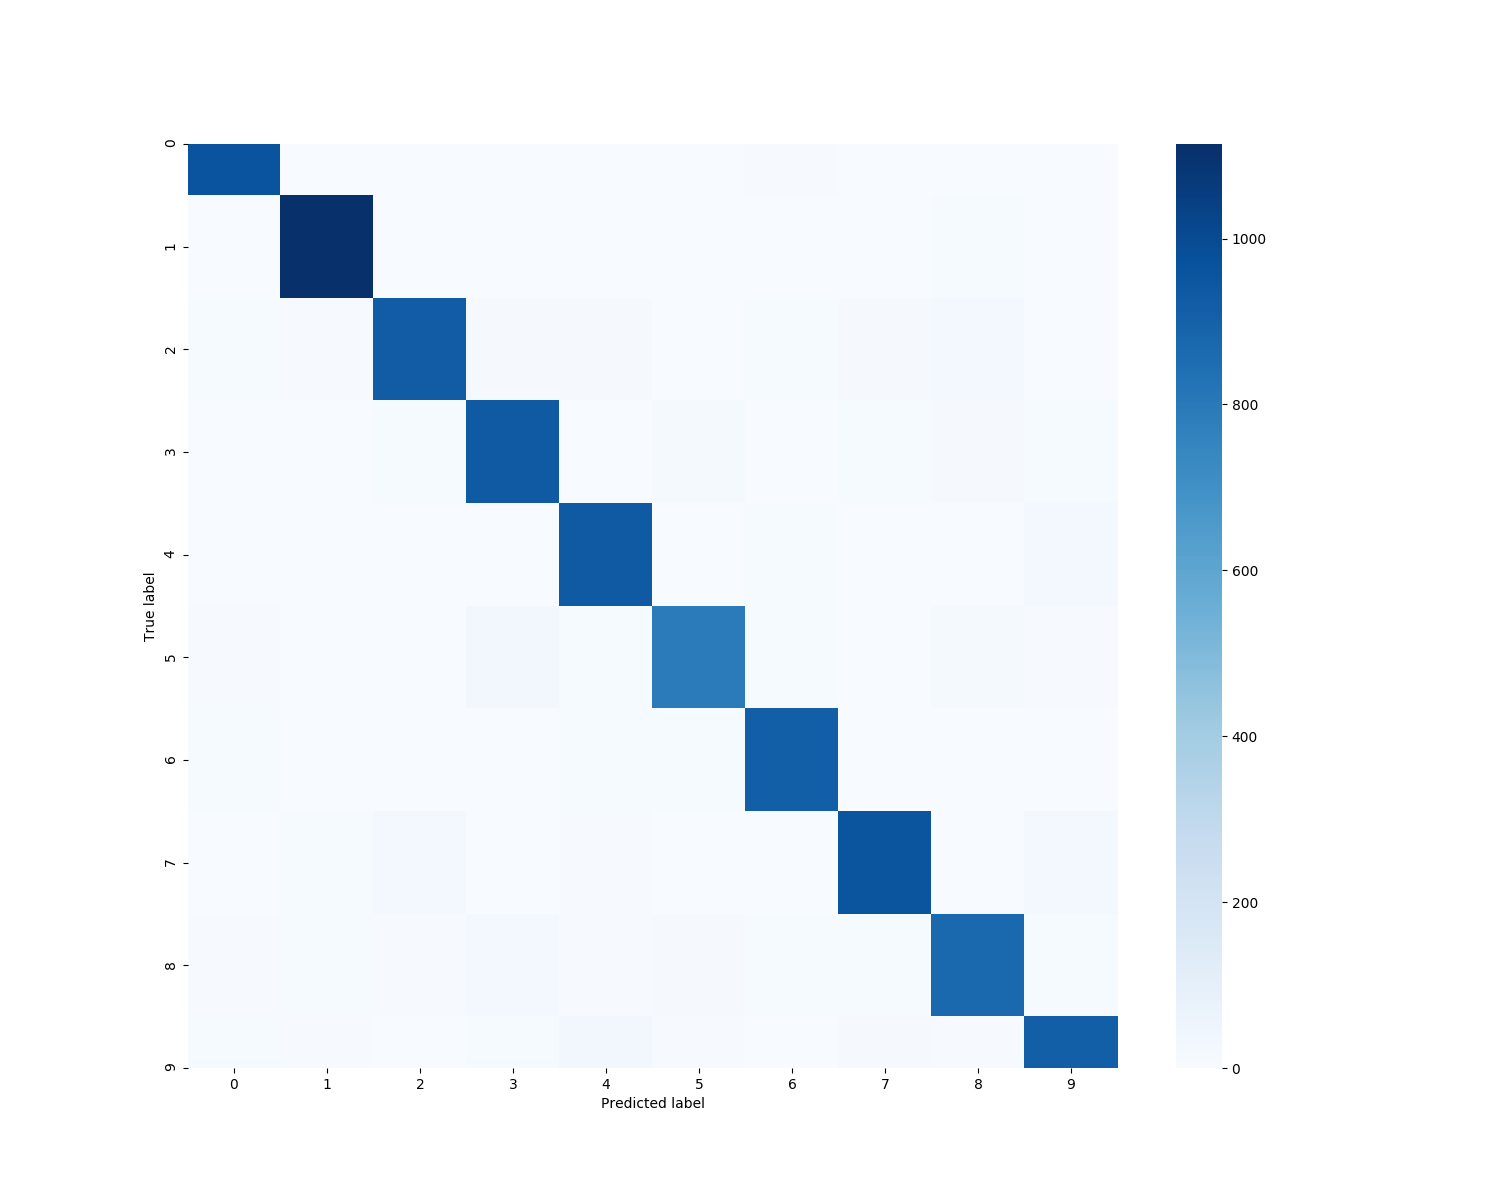

In [20]:
exp.artifacts['confusion_matrix'].render()

In [21]:
exp.artifacts['confusion_matrix'].save()

While CSV artifacts will be converted into `pandas.DataFrames`.

In [22]:
exp.artifacts['predictions'].render().head()

,predictions,targets
0,7,7
1,2,2
2,1,1
3,0,0
4,4,4


In [23]:
exp.artifacts['predictions'].show().head()

/opt/conda/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `show` is deprecated in favor of `render` and will removed in a future release.
  """Entry point for launching an IPython kernel.


,predictions,targets
0,7,7
1,2,2
2,1,1
3,0,0
4,4,4


MP4 artifacts will be downloaded and embedded as an HTML element in the notebook. This can be useful for visualizing dynamics over time.

In [24]:
exp.artifacts['accuracy_movie'].render()

Finally pickle artifacts will the restored to the Python object they originally represented. However, since `pickle` does not have a proper detectable content-type they will be only recognized as `Artifacts` without any more specific type. We can use the `as_type` method to interpret an artifact as an artifact of a more specific or just different type. In our example we just saved the data frame we already have as CSV as a pickle file as well.

In [25]:
pickle_artifact = exp.artifacts['predictions_df'].as_type(incense.artifact.PickleArtifact)
pickle_artifact.render().head()

,predictions,targets
0,7,7
1,2,2
2,1,1
3,0,0
4,4,4


## Metrics

`.metrics` works similar to `.artifacts`, but maps from metrics names to `pandas.Series`. Therefore, metrics can easily be plotted.

In [26]:
exp.metrics.keys()

dict_keys(['training_loss', 'training_acc', 'test_loss', 'test_acc'])

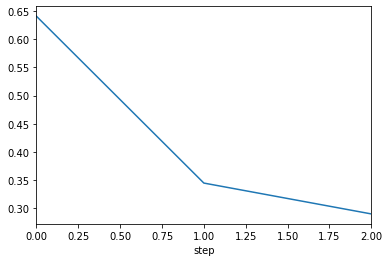

In [27]:
exp.metrics['training_loss'].plot()

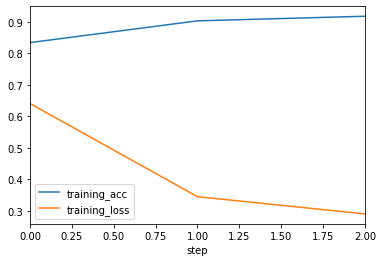

In [28]:
exp.metrics['training_acc'].plot()
exp.metrics['training_loss'].plot()
plt.legend()

## Projecting onto DataFrames
Often you want to pull experiment attributes and metrics into a dataframe. Either just to get and overview or do a custom analysis. You can easily transform a `QuerySet` of experiments by calling `project` on it. Pass a list of dot separated paths that point to some value in the experiment model to the `on` parameter. By default the columns will be named as the last element in the path.

In [29]:
exps = loader.find_by_ids([1,2,3])
exps.project(on=["experiment.name", "config.optimizer", "config.epochs"])

,name,optimizer,epochs
exp_id,,,
1,example,sgd,1
2,example,sgd,3
3,example,adam,1


If a path points to a value that is non-scalar, e.g. a metric, you can pass a dict of the path mapping to a function that reduces the the values to a single value.

In [30]:
exps.project(on=["experiment.name", "config.optimizer", {"metrics.training_loss": np.median}])

,name,optimizer,training_loss_median
exp_id,,,
1,example,sgd,0.637839
2,example,sgd,0.345013
3,example,adam,0.218707


## Saving mulitple artifacts at once
`QuerySet`s mimick the API of single artifacts, so you can also get the artifacts and save all of them. This has the advantage that the download will happen in a multithreaded fashion, which should make things faster for large number of bigger artifacts.

In [31]:
loader.find_all().artifacts["confusion_matrix"].save(to_dir="artifacts")

To match more than one artifact per experiment you can use globbing patterns to `filter` the artifacts. However, you will not get an error if no artifacts are matched for different experiments.

In [32]:
(loader
 .find_all()
 .artifacts
 .filter("*matrix*")
 .save(to_dir="artifacts"))

## Utils
The `utils` module contains related functionality, that might be useful during the manual interpretation of experiments.

In [33]:
from incense import utils

The `find_differing_config_keys` function returns the set of config values that differ in a set of experiments.

In [34]:
exps = loader.find_by_ids([1, 2])
utils.find_differing_config_keys(exps)

{'epochs'}

## Deleting experiments
It is possible to completely delete experiments including their associated metrics and artifacts. Per default the method will ask for confirmation, so we do not accidentally delete our experiments. This can be skipped by passing `confirmed=True`.

In [35]:
exp = loader.find_by_id(2)
exp.delete()

Are you sure you want to delete Experiment(id=2, name=example)? [y/N] N
